In [1]:
# Import the modules

import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.graph_objects as go

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.graphics.tsaplots import acf, plot_acf, plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose   
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima            
import scipy.stats as stats


import warnings
warnings.filterwarnings("ignore")

#Set the default figsize for the future plottings 

plt.rcParams["figure.figsize"] = (15,8)

In [2]:
#Define the function for the stationarity test using both ADF and KPSS

from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import adfuller

def get_adf_kpss(data):
    
    dftest = adfuller(data)
    print(f'adf stat: {dftest[0]}')
    print(f'adf p-value: {dftest[1]}')
    
    kpss_test = kpss(data)
    print(f'kpss stat: {kpss_test[0]}')
    print(f'kpss p-value: {kpss_test[1]}')
    
    if dftest[0] > dftest[4]['5%'] and kpss_test[0] < kpss_test[3]['5%']:
        print('The series is not stationary')
        
    if dftest[0] < dftest[4]['5%'] and kpss_test[0] > kpss_test[3]['5%']:
        print('The series is stationary')
        
    if dftest[0] > dftest[4]['5%'] and kpss_test[0] > kpss_test[3]['5%']:
        print('The series is trend stationary. Trend needs to be removed to make series strict stationary.')
        
    if dftest[0] < dftest[4]['5%'] and kpss_test[0] < kpss_test[3]['5%']:   
        print(' \n The series is difference stationary. Differencing is to be used to make series stationary')
        

In [4]:
#Define the function for Box-Cox invesrion

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))
    

In [5]:
#Set the accuracy metrics for the model

def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE

    return mape, me, mae, mpe, rmse
    

In [6]:
#Get the data from the csv file

df = pd.read_csv('./norway_new_car_sales_by_make.csv')
df

,Year,Month,Make,Quantity,Pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5
...,...,...,...,...,...
4372,2017,1,Nilsson,3,0.0
4373,2017,1,Maserati,2,0.0
4374,2017,1,Ferrari,1,0.0
4375,2017,1,Smart,1,0.0


In [8]:
#Set the columns names to the lower case

cols = pd.DataFrame(list(df.columns), columns = ['col'])

In [9]:
cols['col'] = cols['col'].apply(lambda x: x.lower())

In [10]:
df.columns = list(cols['col'])
df

,year,month,make,quantity,pct
0,2007,1,Toyota,2884,22.7
1,2007,1,Volkswagen,2521,19.9
2,2007,1,Peugeot,1029,8.1
3,2007,1,Ford,870,6.9
4,2007,1,Volvo,693,5.5
...,...,...,...,...,...
4372,2017,1,Nilsson,3,0.0
4373,2017,1,Maserati,2,0.0
4374,2017,1,Ferrari,1,0.0
4375,2017,1,Smart,1,0.0


In [11]:
#Comdine the dates and drop the columns irrelevant for our research

df['date']=pd.to_datetime(dict(year=df['year'], month=df['month'], day=1))
df.set_index('date', inplace=True)
df.drop(columns=['year', 'pct'], inplace=True)


In [12]:
#List all the cars' makers in our data

df['make'].unique()


array(['Toyota', 'Volkswagen', 'Peugeot', 'Ford', 'Volvo', 'Skoda',
       'Opel', 'Audi', 'Honda', 'Mercedes-Benz', 'BMW', 'Citroen',
       'Suzuki', 'Mazda', 'Saab', 'Renault', 'Mitsubishi', 'Nissan',
       'Hyundai', 'Kia', 'Dodge', 'MINI', 'Subaru', 'Lexus', 'Chevrolet',
       'Alfa Romeo', 'Daihatsu', 'Land Rover', 'Fiat', 'Chrysler',
       'Iveco', 'Jaguar', 'Jeep', 'Nilsson', 'Think', 'Smart',
       'Ssangyong', nan, 'Chevrolet US', 'Porsche', 'Cadillac',
       'Aston Martin', 'Morgan', 'Bentley', 'Lancia', 'Maserati', 'Isuzu',
       'Ferrari', 'Koenigsegg', 'Lamborghini', 'Seat', 'Tesla', 'Tata',
       'Dacia', 'Infiniti', 'Lotus', 'Secma', 'Martin Motors', 'Fisker',
       'Westfield', 'Mia', 'McLaren', 'Binz', 'Tazzari', 'Polaris', 'DS'],
      dtype=object)

In [17]:
#Plot the pie-chart and find the bestseller by monthly aggregated data

gr = df.groupby('make', as_index=False).sum()

labels = gr.make
values = gr.quantity


fig = go.Figure(data=[go.Pie(values = values, labels=labels, 
                             textposition='inside', showlegend=True, 
                             hole=0.3, textinfo='label+percent')])
fig.update_layout(
    autosize=False,
    width=800,
    height=500,
     margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
    )
   )
    
fig.show()

In [18]:
#Select the target dataframe and set the monthly index frequency

target = df[df['make']=='Volkswagen']
target.index.freq = 'MS'


In [19]:
#Since the index frequency has been easily set as monthly, 
#our dates are in right order and there are no gaps between them.

#Check if there ary any empty values in our data 

target.isnull().values.any()


False

In [20]:
#Plot the sales data of the selected maker. 
#Use plotly in order to be able to get a close-up view for the selected period

x=''
y='Cars sold per month'
title = 'Volkswagen monthly sales in Norway'

import plotly.express as px

fig = px.line(target, x=target.index, y='quantity', title=title, markers=True)
fig.show()


In [21]:
#Stationarity check with ADF and KPSS tests

get_adf_kpss(target['quantity'])


adf stat: -1.6866611179921152
adf p-value: 0.43799784232307926
kpss stat: 1.285504884620488
kpss p-value: 0.01
The series is trend stationary. Trend needs to be removed to make series strict stationary.


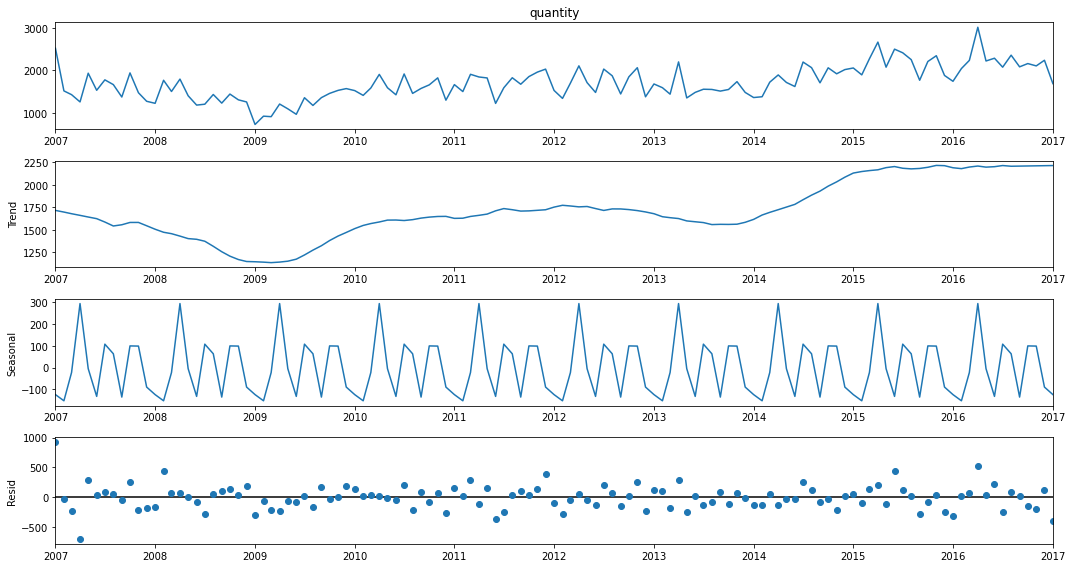

In [16]:
#Seasonal decomposition of our data. Noticed the trend which doesn't have a clear changing pattern. 
#Meeanwhile the seasonal component has a clear cycling picture over the time.

ms = seasonal_decompose(target['quantity'], model='a', extrapolate_trend='freq')
ms.plot();


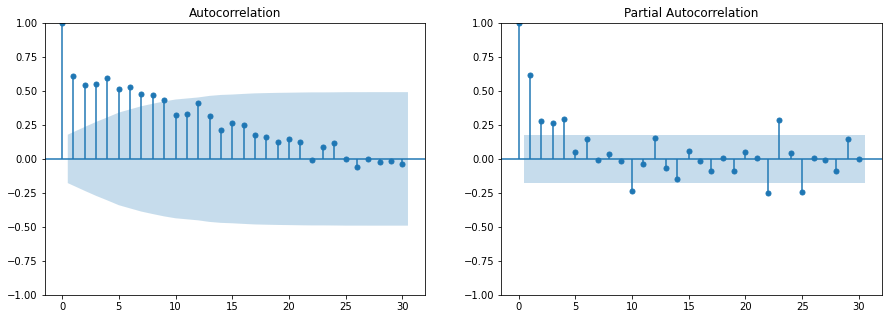

In [26]:
#Plot the autocorrelation and partial autocorrelation of our data.
#There is obvious correlation in our data, however, the plot doesn't follow any specific seasonal pattern.

#We will gradually deduct trend and seasonal components and plot do the plotting again. 

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

plot_acf(target['quantity'], lags = 30, ax = ax1)
plot_pacf(target['quantity'], lags = 30, ax = ax2)

plt.show()


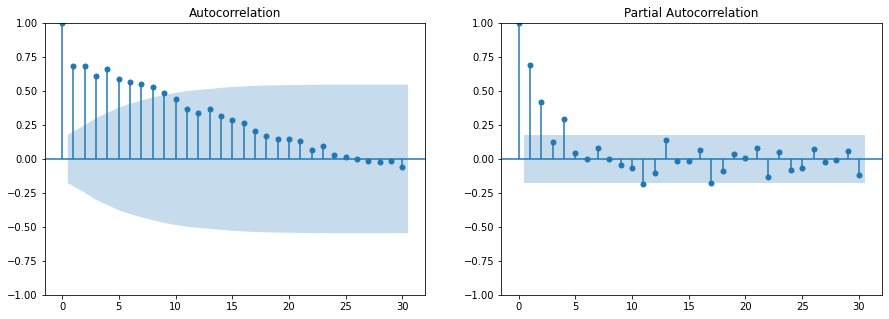

In [27]:
#Deduction of seasonal component didn't change a lot 


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

plot_acf(target['quantity'] - ms.seasonal, lags = 30, ax = ax1)
plot_pacf(target['quantity'] - ms.seasonal, lags = 30, ax = ax2)

plt.show()


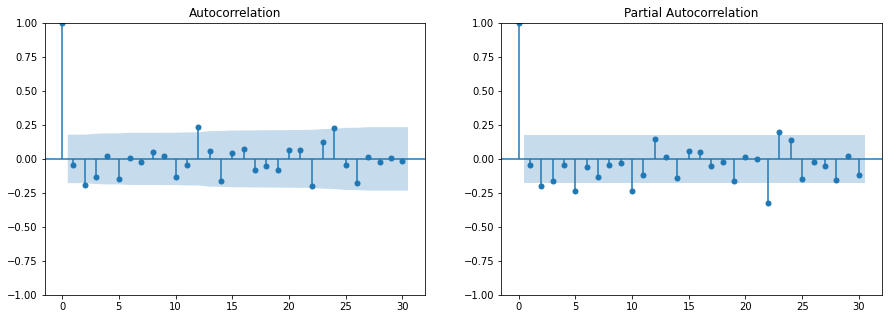

In [28]:
#Having removed the trend, we've received the nearly stationary state fo the series

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

plot_acf(target['quantity'] - ms.trend, lags = 30, ax = ax1)
plot_pacf(target['quantity'] - ms.trend, lags = 30, ax = ax2)

plt.show()


In [17]:
#Finally, let's check the residuals of the series  

get_adf_kpss(ms.resid)

adf stat: -6.643532535688353
adf p-value: 5.335664141825734e-09
kpss stat: 0.039054141702059515
kpss p-value: 0.1
 
 The series is difference stationary. Differencing is to be used to make series stationary


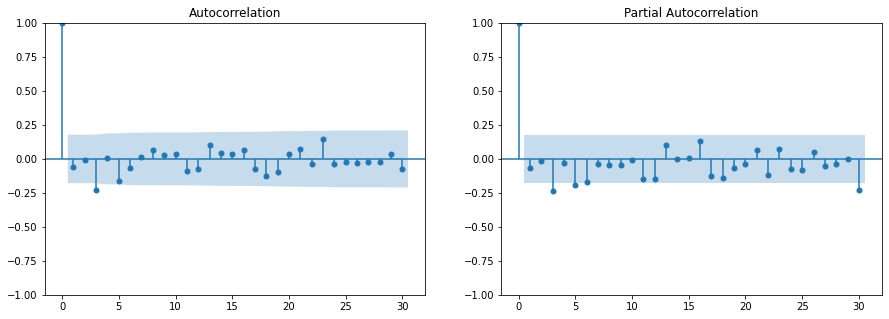

In [18]:

fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15, 5))

plot_acf(ms.resid, lags = 30, ax = ax1)
plot_pacf(ms.resid, lags = 30, ax = ax2)

plt.show()


### As a result, we will use the trend as the exog parameter in our SARIMA model and let the auto_arima find the differencing order. 

In [29]:
#Apply Box-Cox transformation to reduce the variance of our data

from scipy import stats
fit, lmd = stats.boxcox(target['quantity'])
target['y'] = fit


In [30]:
#Find the trend index for using it as exog parameter in our model since the series were found trend stationary.

result_sd = seasonal_decompose(target['y'],
                                model='add', 
                                extrapolate_trend='freq')

trend_index = result_sd.trend.to_frame()
trend_index['month'] = pd.to_datetime(trend_index.index).month


In [286]:
trend_index.head()

,trend,month
date,,
2007-01-01,89.174320,1
2007-02-01,88.644554,2
2007-03-01,88.114788,3
2007-04-01,87.585022,4
2007-05-01,87.055257,5


In [31]:
#Combine the index with the target data 

target['trend_index'] = trend_index['trend']
target.head()


,month,make,quantity,y,trend_index
date,,,,,
2007-01-01,1,Volkswagen,2521,109.451899,89.174320
2007-02-01,2,Volkswagen,1517,83.699355,88.644554
2007-03-01,3,Volkswagen,1428,81.060794,88.114788
2007-04-01,4,Volkswagen,1257,75.758085,87.585022
2007-05-01,5,Volkswagen,1934,95.170644,87.055257


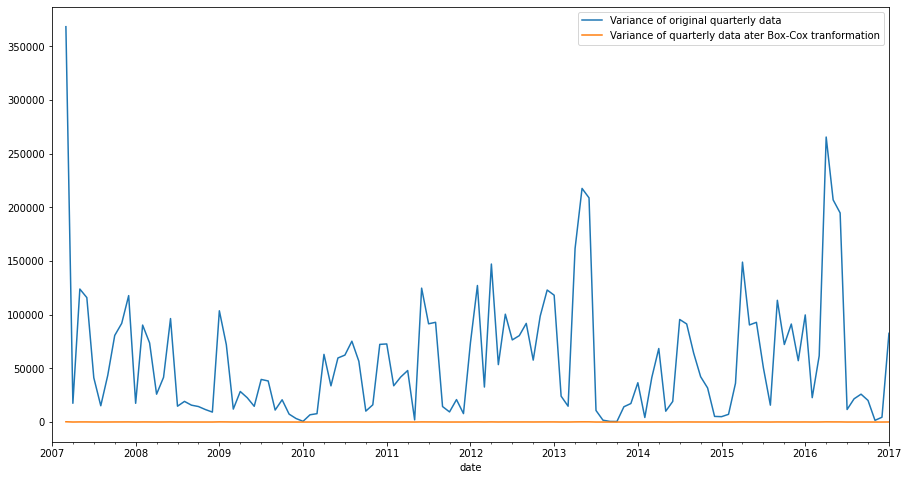

In [217]:
#Plot the rolling variance to check the diference

target.quantity.rolling(window=3).var().rename('Variance of original quarterly data').plot(legend=True);
target.y.rolling(window=3).var().rename('Variance of quarterly data ater Box-Cox tranformation').plot(legend=True);


In [32]:
#Apparantly, the varience has been reduced. Let's check the numeric values.

var1 = target['2016-01-01':'2017-01-01']['quantity']
var2 = target['2016-01-01':'2017-01-01']['y']
for i in range(len(var1)):
    print(f'Original value: {var1[i]}, Box-Cox value: {var2[i]}')
    

Original value: 1743, Box-Cox value: 90.08200363831293
Original value: 2044, Box-Cox value: 97.9914874903703
Original value: 2236, Box-Cox value: 102.74510155196369
Original value: 3017, Box-Cox value: 120.30461884510589
Original value: 2222, Box-Cox value: 102.40531089347192
Original value: 2287, Box-Cox value: 103.97431533936441
Original value: 2076, Box-Cox value: 98.79826276425578
Original value: 2359, Box-Cox value: 105.68738532257684
Original value: 2084, Box-Cox value: 98.99901746185013
Original value: 2161, Box-Cox value: 100.91259590504487
Original value: 2106, Box-Cox value: 99.54918431414329
Original value: 2239, Box-Cox value: 102.81778020600515
Original value: 1688, Box-Cox value: 88.56736190731625


In [193]:
#Find the best SARIMA settings with auto_arima function.

auto_arima(target['y'], X=target[['trend_index']], seasonal='True', m=12, test='kpss', freq='MS').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  121
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -381.955
Date:                            Wed, 23 Mar 2022   AIC                            775.910
Time:                                    00:44:21   BIC                            792.685
Sample:                                01-01-2007   HQIC                           782.723
                                     - 01-01-2017                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
trend_index     0.9997      0.001   1152.642      0.000       0.998       1.001
ar.L1           0.6862      0.085      8.051      0.000       0.519       0.853
ma.L1          -0.9895      0.082    -12.016      0.000      -1.151      -0.828
ar.S.L12        0.9452      0.119      7.919      0.000       0.711       1.179
ma.S.L12       -0.8009      0.224     -3.568      0.000      -1.241      -0.361
sigma2         30.6950      4.864      6.310      0.000      21.161      40.229
===================================================================================
Ljung-Box (L1) (Q):                   0.76   Jarque-Bera (JB):                 2.15
Prob(Q):                              0.38   Prob(JB):                         0.34
Heteroskedasticity (H):               0.53   Skew:                             0.32
Prob(H) (two-sided):                  0.05   Kurtosis:                         3.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [33]:
len(target)

121

In [34]:
#Split the target test for train and test subsets

train = target.iloc[:108]
test = target.iloc[108:]

In [221]:
#Train the SARIMA model with the obtained settings

model = SARIMAX(train['y'], exog=train[['trend_index']], order=(1, 0, 1), seasonal_order=(1,0,1,12), freq='MS')
results = model.fit()
results.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.33407D+00    |proj g|=  2.96487D-01

At iterate    5    f=  3.23537D+00    |proj g|=  9.05968D-02

At iterate   10    f=  3.21847D+00    |proj g|=  2.66975D+00

At iterate   15    f=  3.18685D+00    |proj g|=  2.59219D-01

At iterate   20    f=  3.18410D+00    |proj g|=  1.01683D+00

At iterate   25    f=  3.17901D+00    |proj g|=  4.28459D-02

At iterate   30    f=  3.17649D+00    |proj g|=  6.67865D-01

At iterate   35    f=  3.17182D+00    |proj g|=  5.56646D-01

At iterate   40    f=  3.15939D+00    |proj g|=  2.48170D+00

At iterate   45    f=  3.15744D+00    |proj g|=  1.34401D-01

At iterate   50    f=  3.15705D+00    |proj g|=  4.85737D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -340.962
Date:                            Wed, 23 Mar 2022   AIC                            693.924
Time:                                    20:25:51   BIC                            710.017
Sample:                                01-01-2007   HQIC                           700.449
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
trend_index     0.9996      0.001   1249.433      0.000       0.998       1.001
ar.L1           0.6809      0.086      7.907      0.000       0.512       0.850
ma.L1          -0.9961      0.208     -4.796      0.000      -1.403      -0.589
ar.S.L12        0.9937      0.169      5.863      0.000       0.662       1.326
ma.S.L12       -0.9450      0.736     -1.283      0.199      -2.388       0.499
sigma2         29.1985     13.908      2.099      0.036       1.939      56.458
===================================================================================
Ljung-Box (L1) (Q):                   0.64   Jarque-Bera (JB):                 3.27
Prob(Q):                              0.42   Prob(JB):                         0.20
Heteroskedasticity (H):               0.46   Skew:                             0.42
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

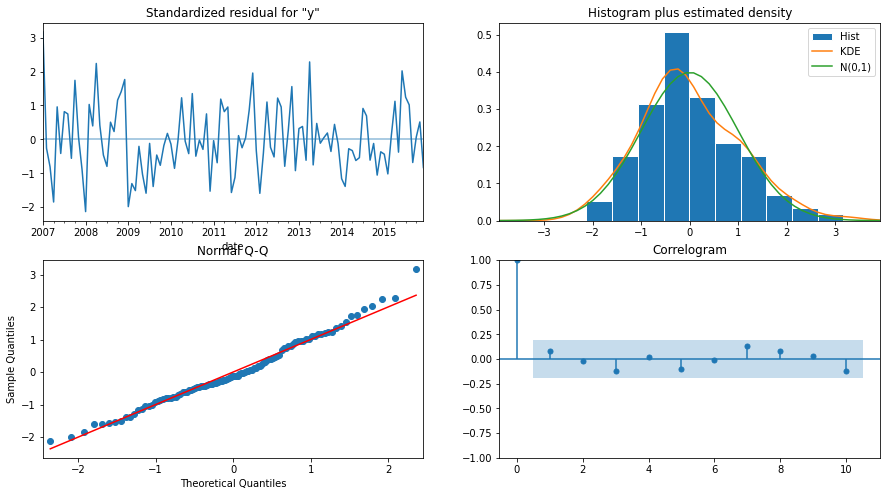

In [222]:
results.plot_diagnostics();

#### From the above plotting, we see that the KDE line follows closely with a normal distribution.

#### The QQ-plot shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution.

#### The residuals over time (top left plot) don’t display any obvious seasonality and appear to be white noise. 

##### The same is confirmed by the autocorrelation plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

##### This is a good indication that the residuals are normally distributed. 
##### And all of this implies that the model produces the satisfactory fit.


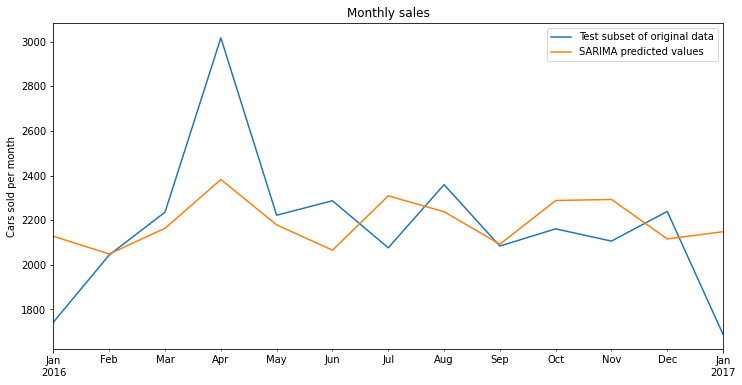

In [333]:
#Cross validation test of SARIMA predited values

start = len(train)
end = len(train) + len(test)-1
sarima_predictions = results.predict(start = start, end = end, 
                                     exog = test[['trend_index']],
                                     typ = 'levels')

title = 'Monthly sales'
ylabel = 'Cars sold per month'
xlabel = ''

ax = test['quantity'].plot(legend = True,figsize = (12,6),title = title, label='Test subset of original data')
invboxcox(sarima_predictions, lmd).plot(legend = True, label = 'SARIMA predicted values')

ax.autoscale(axis = 'x',tight = True)
ax.set(xlabel = xlabel, ylabel = ylabel);

In [325]:
#Check our predictions with the accuracy metrics with the function defined above. 

sarima_mape, sarima_me, sarima_mae, sarima_mpe, sarima_rmse = forecast_accuracy(invboxcox(sarima_predictions,lmd), test['quantity'])

print(f"The received MAPE implies that the selected SARIMA model \n"
      f"approximately \033[1m  {100.0 - sarima_mape*100} % \033[0m accurate  in predicting the \n"
      f"next \033[1m  {end - start+1} \033[0m observations. \n"
    f"\n"
      f"The rest of the metrics are as follows: \n"
      f"ME: {sarima_me}, \n"
      f"MAE: {sarima_mae}, \n"
      f"MPE: {sarima_mpe}, \n"
      f"RMSE: {sarima_rmse}")


The received MAPE implies that the selected SARIMA model 
approximately   90.5798418165945 %  accurate  in predicting the 
next   13  observations. 

The rest of the metrics are as follows: 
ME: 14.40062899356868, 
MAE: 201.59130077466136, 
MPE: 0.022560381748378846, 
RMSE: 270.92512123168655


In [226]:
#Train and fit the model on the full data. And predict the sales for the one year then.

model_full = SARIMAX(target['y'], exog=target[['trend_index']], order=(1, 0, 1), seasonal_order=(1,0,1,12), freq='MS')
results_full = model_full.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.23191D+00    |proj g|=  1.19913D-01

At iterate    5    f=  3.22367D+00    |proj g|=  1.80891D+00

At iterate   10    f=  3.20194D+00    |proj g|=  3.63512D-02


 This problem is unconstrained.



At iterate   15    f=  3.18580D+00    |proj g|=  7.91912D-01

At iterate   20    f=  3.16769D+00    |proj g|=  5.46468D-01

At iterate   25    f=  3.16692D+00    |proj g|=  3.66814D-02

At iterate   30    f=  3.16657D+00    |proj g|=  1.17490D+00

At iterate   35    f=  3.16488D+00    |proj g|=  5.82909D-02

At iterate   40    f=  3.16467D+00    |proj g|=  4.44191D-01

At iterate   45    f=  3.15780D+00    |proj g|=  3.36340D+00

At iterate   50    f=  3.15665D+00    |proj g|=  3.22559D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     58      1     0     0   3.226D-03   3.157D+00
  F =   3.15665297358

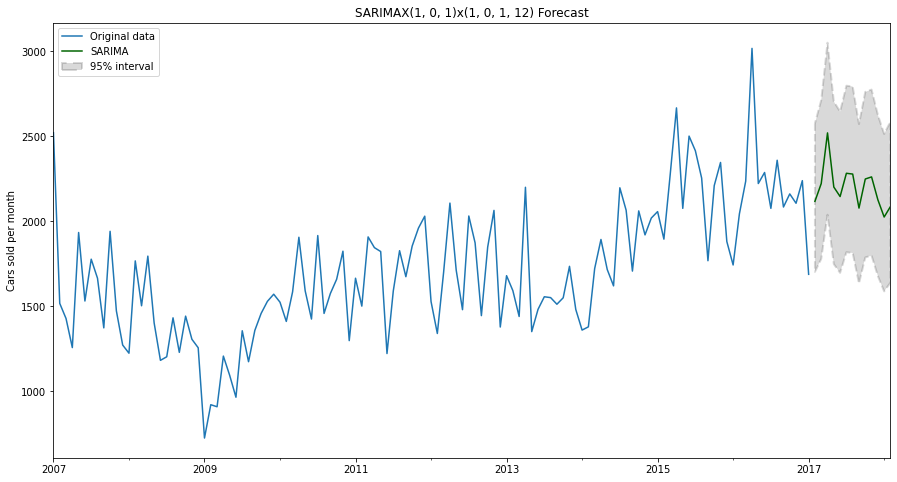

In [319]:
#Plot the results of the Prophet forecast

n_periods = 13


sarima_forecast = results_full.get_forecast(n_periods, exog=trend_index.trend[-n_periods:])

conf = sarima_forecast.conf_int()

target['quantity'].plot(label='Original data').set(xlabel='', ylabel='Cars sold per month')
invboxcox(sarima_forecast.predicted_mean,lmd).plot(color='darkgreen', label='SARIMA')
plt.fill_between(conf.index, invboxcox(conf['lower y'],lmd), 
                 invboxcox(conf['upper y'],lmd), 
                 color='k', alpha=.15, linestyle='--', lw=2, 
                label = '95% interval')

plt.title("SARIMAX(1, 0, 1)x(1, 0, 1, 12) Forecast")
plt.legend(loc='upper left')
plt.show()



Sarima model forecast appeared to be generally satisfactory and followed the common pattern of the series with good metrics.


In [228]:
#Import the library for th esecond model.

from fbprophet import Prophet


In [229]:
#Transform the data in order to meet the model requirements

predictions = 13

df1 = target.reset_index()
df1.drop(columns=['make', 'month', 'y', 'trend_index'], inplace=True)
df1.columns = ['ds', 'y']
train_df = df1[:-predictions] 


In [230]:
#Train the Prophet model 

m = Prophet(seasonality_mode='additive')
m.fit(train_df)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.09917


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       188.947    0.00253077       79.5657   2.385e-05       0.001      153  LS failed, Hessian reset 
      99       189.133   8.18018e-05       60.5314      0.2686           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       189.361    0.00390291        71.009   4.241e-05       0.001      270  LS failed, Hessian reset 
     199       189.467   2.20299e-05       46.7561      0.1978      0.7369      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       189.471   1.06787e-05       42.0538   2.153e-07       0.001      405  LS failed, Hessian reset 
     299       189.812     0.0027606       55.5493           1           1      518   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       189.914   1.79424e-06  

In [231]:
#Forecast the data for one year to check the model on the test data.

future = m.make_future_dataframe(periods=predictions, freq='MS')
forecast = m.predict(future)

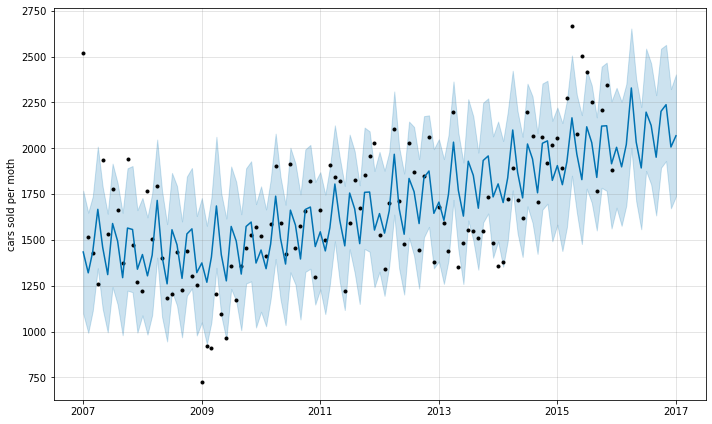

In [233]:
#Plot the forecast with the Prophet inbuilt method

m.plot(forecast, xlabel='', ylabel='cars sold per month');

In [234]:
pr = forecast[-predictions:]['yhat']

In [324]:
#Check the model's metrics. 

pr_mape, pr_me, pr_mae, pr_mpe, pr_rmse = forecast_accuracy(pr, df1[-predictions:]['y'])

print(f"The received MAPE implies that the selected Prophet model \n"
      f"approximately \033[1m  {100.0 - pr_mape*100} % \033[0m accurate  in predicting the \n"
      f"next \033[1m  {predictions} \033[0m observations. \n"
      f"\n"
      f"The rest of the metrics are as follows: \n"
      f"ME: {pr_me}, \n"
      f"MAE: {pr_mae}, \n"
      f"MPE: {pr_mpe}, \n"
      f"RMSE: {pr_rmse}")


The received MAPE implies that the selected Prophet model 
approximately   88.96307060616 %  accurate  in predicting the 
next   13  observations. 

The rest of the metrics are as follows: 
ME: -99.3746532375908, 
MAE: 243.56792025110548, 
MPE: -0.030973862750652194, 
RMSE: 291.5323569178151


In [236]:
#Collect the data into one data frame

prophet_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df1.set_index('ds'))

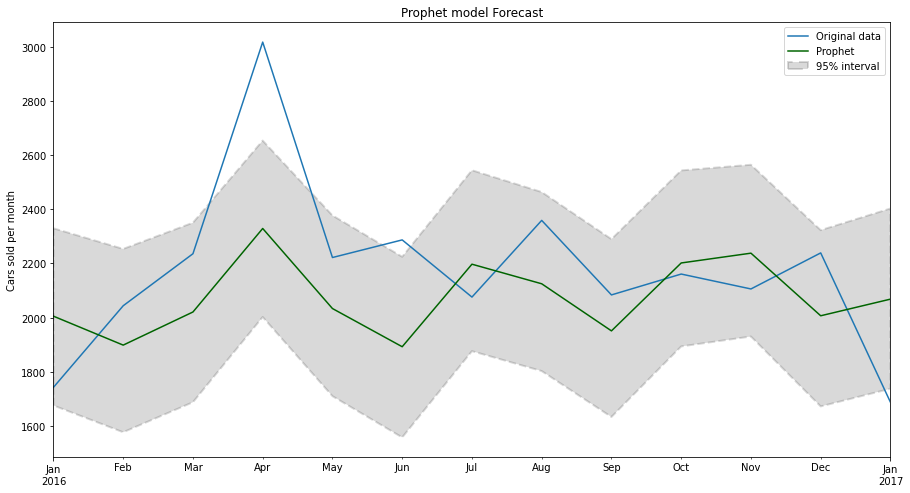

In [321]:
#Plot the results against the test data to have a close-up view 

test['quantity'].plot(label='Original data')

prophet_df['yhat'].tail(predictions).plot(color='darkgreen', 
                                          label='Prophet').set(xlabel='', ylabel='Cars sold per month')

plt.fill_between(test.index, prophet_df['yhat_lower'].tail(predictions), 
                 prophet_df['yhat_upper'].tail(predictions), color='k', 
                 alpha=.15, label='95% interval', linestyle='--', lw=2)

plt.title("Prophet model Forecast")
plt.legend();

In [238]:
#Train the model on the full data and repeat the above steps with plotting

m_full = Prophet(seasonality_mode='additive')
m_full.fit(df1)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.23135
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


      99       229.995    0.00193818       71.9194      0.7644      0.7644      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       230.064   7.57919e-05       34.9435   1.301e-06       0.001      173  LS failed, Hessian reset 
     199       230.383    3.4573e-05       49.3441      0.2611           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       230.391   2.96076e-05       69.9126    4.05e-07       0.001      403  LS failed, Hessian reset 
     257       230.391    1.2491e-06       44.3493   2.894e-08       0.001      452  LS failed, Hessian reset 
     291       230.391   1.06279e-06       62.0696   1.686e-08       0.001      532  LS failed, Hessian reset 
     298       230.392   7.79855e-09       56.4514     0.01089           1      544   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


In [239]:
future1 = m_full.make_future_dataframe(periods=predictions, freq='MS')
forecast1 = m_full.predict(future1)

In [240]:
prophet_df1 = forecast1.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df1.set_index('ds'))

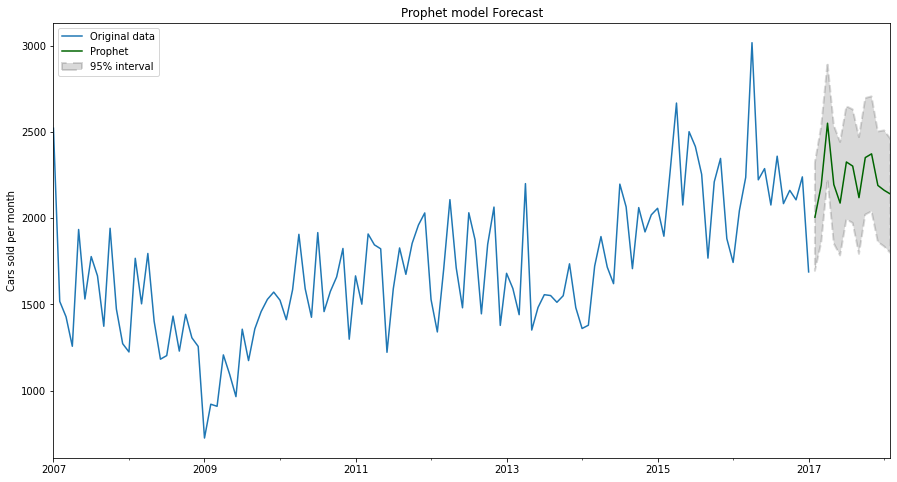

In [322]:
#Plot the forecasr against the full data

target['quantity'].plot(label='Original data')

prophet_df1['yhat'].tail(predictions).plot(color='darkgreen', label='Prophet').set(xlabel='', 
                                                                                   ylabel='Cars sold per month')

plt.fill_between(prophet_df1.tail(predictions).index, prophet_df1['yhat_lower'].tail(predictions), 
                 prophet_df1['yhat_upper'].tail(predictions), color='k', 
                 alpha=.15, label='95% interval', linestyle='--', lw=2)

plt.title("Prophet model Forecast")
plt.legend(loc='upper left');

### Prophet model forecast appeared to be generally satisfactory and followed the common pattern of the series with good metrics. The vissual appearance and metrics didn't show the sicnificant difference with SARIMA model predictions. 


In [108]:
#Import the final model whoch is ETS Model

from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [129]:
#Split the target data frame

train = target.iloc[:108]
test = target.iloc[108:]


In [152]:
#Train the model using trend, seasonal and error settings

model_ets = ETSModel(
    train['quantity'],
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=False,
    seasonal_periods=12,
    freq='MS',
    initialization_method='heuristic'
)
fit_ets = model_ets.fit()


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.07035D+00    |proj g|=  8.99900D-01

At iterate    1    f=  6.95461D+00    |proj g|=  1.99950D-01

At iterate    2    f=  6.94342D+00    |proj g|=  1.52833D-01

At iterate    3    f=  6.93849D+00    |proj g|=  9.52690D-02

At iterate    4    f=  6.93611D+00    |proj g|=  2.95815D-02

At iterate    5    f=  6.93595D+00    |proj g|=  6.31735D-03

At iterate    6    f=  6.93594D+00    |proj g|=  3.23483D-03

At iterate    7    f=  6.93594D+00    |proj g|=  1.95683D-03

At iterate    8    f=  6.93594D+00    |proj g|=  1.41931D-04

At iterate    9    f=  6.93594D+00    |proj g|=  1.26565D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

In [153]:
#Set the prediction period for the last year according to our test data frame

pred = fit_ets.get_prediction(start="2016", end="2017")


In [157]:
#Look through the summary of returned values

df3 = pred.summary_frame(alpha=0.05)
df3.head()


,mean,pi_lower,pi_upper
2016-01-01,2001.570447,1513.760695,2489.380199
2016-02-01,2078.934025,1567.755570,2590.112479
2016-03-01,2176.747024,1642.089891,2711.404157
2016-04-01,2407.353205,1849.093923,2965.612487
2016-05-01,2189.824532,1607.828398,2771.820666


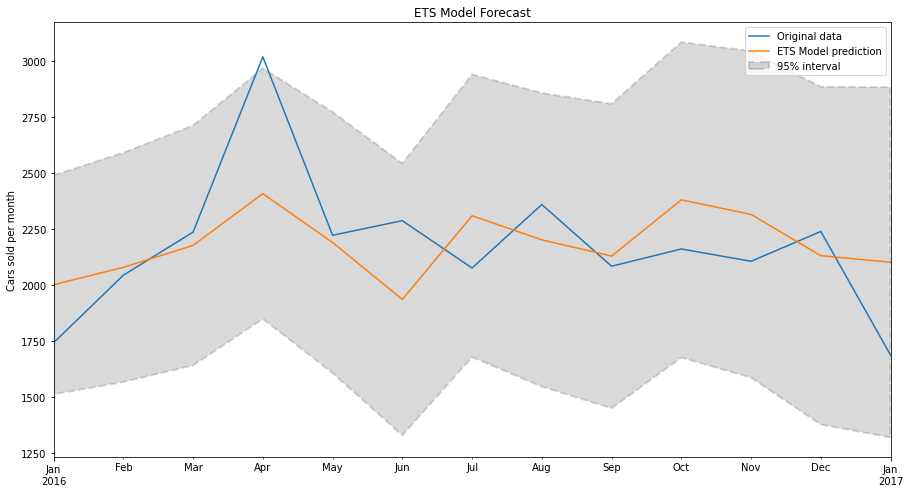

In [330]:
#Plot the result of ETS Model test predictions 

test['quantity'].plot(label="Original data")

df3['mean'].plot(label="ETS Model prediction").set(xlabel='', ylabel='Cars sold per month')

plt.fill_between(df3.index, df3['pi_lower'], 
                 df3['pi_upper'], color='k', 
                 alpha=.15, label='95% interval', linestyle='--', lw=2)


plt.title("ETS Model Forecast")
plt.legend();


In [327]:
#Check the ETS metrics

frcst = df3['mean']
actual = test['quantity']

ets_mape, ets_me, ets_mae, ets_mpe, ets_rmse = forecast_accuracy(frcst, actual)

print(f"The received MAPE implies that the selected ETS Model \n"
      f"approximately \033[1m  {100.0 - ets_mape*100} % \033[0m accurate  in predicting the \n"
      f"next \033[1m  {len(df3)} \033[0m observations. \n"
      f"\n"
      f"The rest of the metrics are as follows: \n"
      f"ME: {ets_me}, \n"
      f"MAE: {ets_mae}, \n"
      f"MPE: {ets_mpe}, \n"
      f"RMSE: {ets_rmse}")


The received MAPE implies that the selected ETS Model 
approximately   90.33743445558385 %  accurate  in predicting the 
next   13  observations. 

The rest of the metrics are as follows: 
ME: 7.372648888730999, 
MAE: 210.00649485463015, 
MPE: 0.017959551907327256, 
RMSE: 266.3963811129286


In [158]:
#Train the ETS model on the full data

model_ets_full = ETSModel(
    target['quantity'],
    error="add",
    trend="add",
    seasonal="add",
    damped_trend=False,
    seasonal_periods=12,
    freq='MS',
    initialization_method='heuristic'
)

fit_ets_full = model_ets_full.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.08220D+00    |proj g|=  8.99900D-01

At iterate    1    f=  6.97322D+00    |proj g|=  1.99859D-01

At iterate    2    f=  6.95958D+00    |proj g|=  1.42565D-01

At iterate    3    f=  6.95537D+00    |proj g|=  9.03884D-02

At iterate    4    f=  6.95326D+00    |proj g|=  3.78847D-02

At iterate    5    f=  6.95289D+00    |proj g|=  6.50457D-03

At iterate    6    f=  6.95287D+00    |proj g|=  1.37419D-03

At iterate    7    f=  6.95287D+00    |proj g|=  9.70335D-04

At iterate    8    f=  6.95287D+00    |proj g|=  7.43583D-04

At iterate    9    f=  6.95287D+00    |proj g|=  3.75255D-04

At iterate   10    f=  6.95287D+00    |proj g|=  9.32587D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

In [161]:
#Set the forecast for one year 

pred_f = fit_ets_full.get_prediction(start="2017", end="2018")
df4 = pred_f.summary_frame(alpha=0.05)

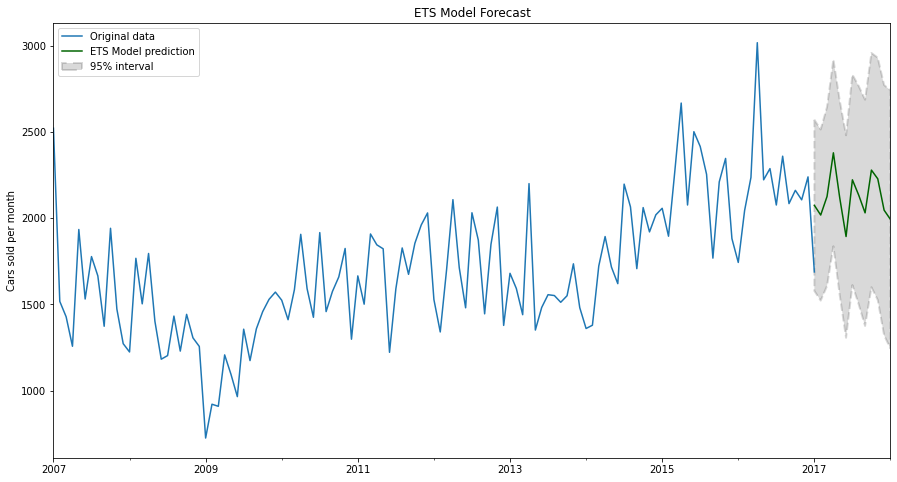

In [334]:
#Plot the ETS Model forecasted data

target['quantity'].plot(label="Original data");

df4['mean'].plot(label="ETS Model prediction", color='darkgreen').set(xlabel='', ylabel='Cars sold per month')

plt.fill_between(df4.index, df4['pi_lower'], 
                 df4['pi_upper'], color='k', 
                 alpha=.15, label='95% interval', linestyle='--', lw=2)


plt.title("ETS Model Forecast")
plt.legend();


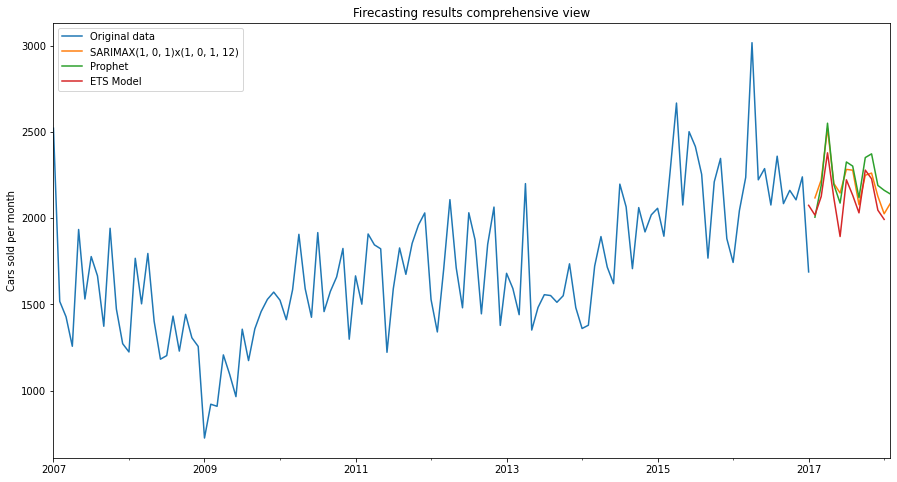

In [338]:
#Plot all the forecasting results

target['quantity'].plot(label = 'Original data')

(invboxcox(sarima_forecast.predicted_mean,lmd)).plot(label = 'SARIMAX(1, 0, 1)x(1, 0, 1, 12)')

(prophet_df1.yhat.tail(predictions)).plot(label = 'Prophet').set(
                                                    xlabel='', 
                                                    ylabel='Cars sold per month')

df4['mean'].plot(label = 'ETS Model')

plt.title('Firecasting results comprehensive view')
plt.legend();


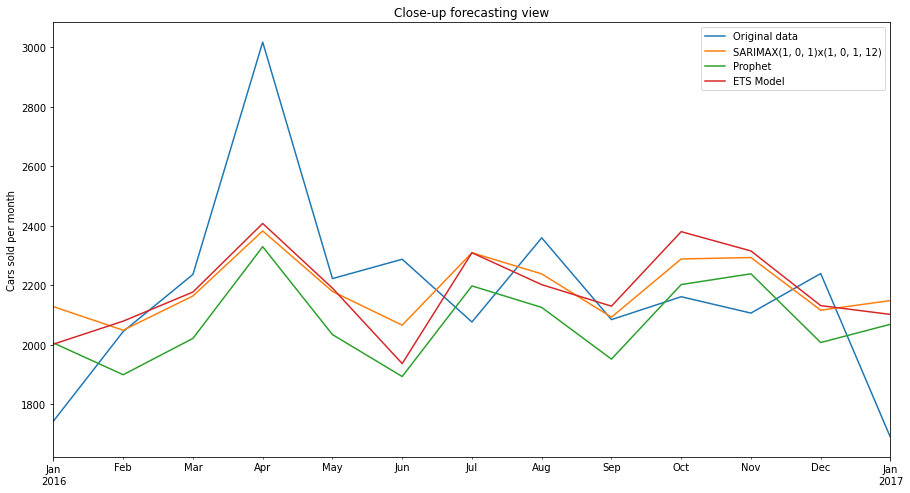

In [339]:
#Plot the predictions of the test data for all three models to have a close - up view

test['quantity'].plot(label = 'Original data')

invboxcox(sarima_predictions, lmd).plot(legend=True, label = 'SARIMAX(1, 0, 1)x(1, 0, 1, 12)')

(prophet_df.yhat.tail(predictions)).plot(label = 'Prophet').set(
                                                    xlabel='', 
                                                    ylabel='Cars sold per month')

df3['mean'].plot(label = 'ETS Model')

plt.title('Close-up forecasting view')
plt.legend();

In [279]:
#Gather the metrics of all models

pd.DataFrame(np.array([[sarima_mape, sarima_me, sarima_mae, sarima_mpe, sarima_rmse],
                       [pr_mape, pr_me, pr_mae, pr_mpe, pr_rmse], 
                       [ets_mape, ets_me, ets_mae, ets_mpe, ets_rmse]]),
            columns=['MAPE', 'ME', 'MAE', 'MPE', 'RMSE'], 
            index=['SARIMA', 'Prophet', 'ETS Model'])


,MAPE,ME,MAE,MPE,RMSE
SARIMA,0.094202,14.400629,201.591301,0.022560,270.925121
Prophet,0.110369,-99.374653,243.567920,-0.030974,291.532357
ETS Model,0.096626,7.372649,210.006495,0.017960,266.396381


### Finally, having compared the metrics of all three models, it was concluded that all of them have more or less the same accuracy level in predicting of the same number of observations.

### Apparently, the significant RMSE and MAE values were caused by "up and down" spike in the original data in the beginning of 2016 which didn't follow both trend and seasonal patterns. Otherwise, the fitted models appeared to be following the general behavior of the original data. The mentioned surge in the beginning if the testing data set could be caused by the seasonal sales by the dealers or by the similar factors. 

### And while the metrics are pretty much the same, the ETS and SARIMA (Auto_arima) models showed a slight better performance. However, the ETS Model significantly less time consuming and doesn't require as much manipulations with data as SARIMA does. 

### All the models can be improved further for a better performance after more thorough analysis of the initial data.  
